In [1]:
import csv
import time
import datetime
import json
import sys
import pandas as pd
import numpy as np

# data read

In [2]:
def get_ID_list(txtPath):
    ID_lists = []
    with open(txtPath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip('\n')
        ID_lists.append(line.split(','))
    return ID_lists

def get_label_list(txtPath):
    label_list = []
    with open(txtPath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        label_list.append(line.strip('\n').split(',')[1])
    return label_list

def get_timestamp(time_str):
    return time.mktime(datetime.datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S.%fZ").timetuple())

def get_hashtag(tweet_object):
    if 'entities' in tweet_object.keys():
        if 'hashtags' in tweet_object['entities'].keys():
            hashtag_list = []
            for elem in tweet_object['entities']['hashtags']:
                hashtag_list.append(elem['tag'])
            return hashtag_list
    return None

In [3]:
ID_list = get_ID_list('covid_new.txt')
label_list = get_label_list('covid.predictions.txt')[1:]
assert len(ID_list)==len(label_list)

openTrainData = open('covid.json')
covid_dict = json.load(openTrainData)
openTrainData.close()

In [4]:
for row_index in range(len(ID_list)):
    for tweetid in ID_list[row_index]:
        covid_dict[tweetid]['label'] = label_list[row_index]
        covid_dict[tweetid]['timestamp'] = get_timestamp(covid_dict[tweetid]['created_at'])
        covid_dict[tweetid]['hashtags'] = get_hashtag(covid_dict[tweetid])

In [5]:
assert len(list(covid_dict.keys()))==201839

In [6]:
covid_df = pd.DataFrame.from_dict(covid_dict, orient='index',
                       columns=['text', 'lang','hashtags', 'timestamp', 'source', 'created_at', 'author_id', 'label'])
covid_df.head()

,text,lang,hashtags,timestamp,source,created_at,author_id,label
1272262651100434433,"According to the New York Times, Warner Bros. ...",en,[Tenet],1.592130e+09,Twitter for iPhone,2020-06-14T20:20:28.000Z,1011312260805996547,0
1287153210990395392,Hurricane Hanna has made landfall in Texas.\n\...,en,None,1.595680e+09,Sprout Social,2020-07-25T22:30:14.000Z,44513878,0
1287191952115605505,@TexasTribune Guess what the cause of death is...,en,None,1.595689e+09,Twitter for iPhone,2020-07-26T01:04:10.000Z,1266937699128217602,0
1266555444283179008,Monkeys on the loose in India with stolen coro...,en,None,1.590769e+09,SocialFlow,2020-05-30T02:22:04.000Z,1917731,0
1258212704961155073,@BelAkinyii Let's not play blind that the work...,en,None,1.588780e+09,Twitter Web App,2020-05-07T01:50:59.000Z,1170754239272050688,0


In [7]:
covid_df.info

<bound method DataFrame.info of                                                                   text lang  \
1272262651100434433  According to the New York Times, Warner Bros. ...   en   
1287153210990395392  Hurricane Hanna has made landfall in Texas.\n\...   en   
1287191952115605505  @TexasTribune Guess what the cause of death is...   en   
1266555444283179008  Monkeys on the loose in India with stolen coro...   en   
1258212704961155073  @BelAkinyii Let's not play blind that the work...   en   
...                                                                ...  ...   
1265875761111666688  @seanhannity Trump total meltdown Coronavirus ...   en   
1265822646215872514  @seanhannity New York Post- January 5, 2020 " ...   en   
1265936765988286465  @seanhannity Everything was fine before COVID-...   en   
1265825373868228608  @seanhannity Sad to say, NY and NYC are train ...   en   
1265813858318454785  @seanhannity Breaking News: What Fox News won'...   en   

                   

In [8]:
covid_en_df = covid_df[covid_df.lang=='en']

In [9]:
covid_en_df.info

<bound method DataFrame.info of                                                                   text lang  \
1272262651100434433  According to the New York Times, Warner Bros. ...   en   
1287153210990395392  Hurricane Hanna has made landfall in Texas.\n\...   en   
1287191952115605505  @TexasTribune Guess what the cause of death is...   en   
1266555444283179008  Monkeys on the loose in India with stolen coro...   en   
1258212704961155073  @BelAkinyii Let's not play blind that the work...   en   
...                                                                ...  ...   
1265875761111666688  @seanhannity Trump total meltdown Coronavirus ...   en   
1265822646215872514  @seanhannity New York Post- January 5, 2020 " ...   en   
1265936765988286465  @seanhannity Everything was fine before COVID-...   en   
1265825373868228608  @seanhannity Sad to say, NY and NYC are train ...   en   
1265813858318454785  @seanhannity Breaking News: What Fox News won'...   en   

                   

# rumor/norumor split

In [14]:
covid_rm = covid_en_df[covid_en_df.label=='1']
covid_nr = covid_en_df[covid_en_df.label=='0']
print(f'rumor number: {len(covid_rm)}, no rumor number: {len(covid_nr)}')

rumor number: 35895, no rumor number: 165595


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter, defaultdict
from copy import deepcopy
from nltk.stem import WordNetLemmatizer

In [16]:
hashtag_list = covid_en_df["hashtags"].values.tolist()
rumor_hashtag_list = covid_en_df.loc[covid_en_df["label"] == '1']["hashtags"].values.tolist()
norumor_hashtag_list = covid_en_df.loc[covid_en_df["label"] == '0']["hashtags"].values.tolist()

In [17]:
def to_hashtag_dict(list):
    
    lemmatizer = WordNetLemmatizer()
    hashtagdict = defaultdict(int)
    for row in list:
        if not row is None:
            for hashtag in row:
                hashtagdict[lemmatizer.lemmatize(hashtag.lower())]+=1
    return hashtagdict

HASHTAGS_POPLIST = ['covid19', 'coronavirus', 'coronaviruspandemic', 'covid_19', 'covid', 
                   'pandemic', 'corona', 'covid19pandemic', 'covidー19', 'covid__19', 'covid2019']

def pop_hashtag(dict1, poplist=HASHTAGS_POPLIST):
    tdict = deepcopy(dict1)
    for k in dict1.keys():
        if k in HASHTAGS_POPLIST:
            tdict.pop(k)
    return tdict

In [18]:
hashtag_dict = to_hashtag_dict(hashtag_list)
rumor_hashtag_dict = to_hashtag_dict(rumor_hashtag_list)
norumor_hashtag_dict = to_hashtag_dict(norumor_hashtag_list)

hashtag_dict = pop_hashtag(hashtag_dict)
rumor_hashtag_dict = pop_hashtag(rumor_hashtag_dict)
norumor_hashtag_dict = pop_hashtag(norumor_hashtag_dict)

hashtag_sorted = [[item[0], item[1]] for item in sorted(hashtag_dict.items(), key=lambda item: item[1], reverse=True)] 
rumor_hashtag_sorted = [[item[0], item[1]] for item in sorted(rumor_hashtag_dict.items(), key=lambda item: item[1], reverse=True)] 
norumor_hashtag_sorted = [[item[0], item[1]] for item in sorted(norumor_hashtag_dict.items(), key=lambda item: item[1], reverse=True)]


# Hashtags analysis

## frequency

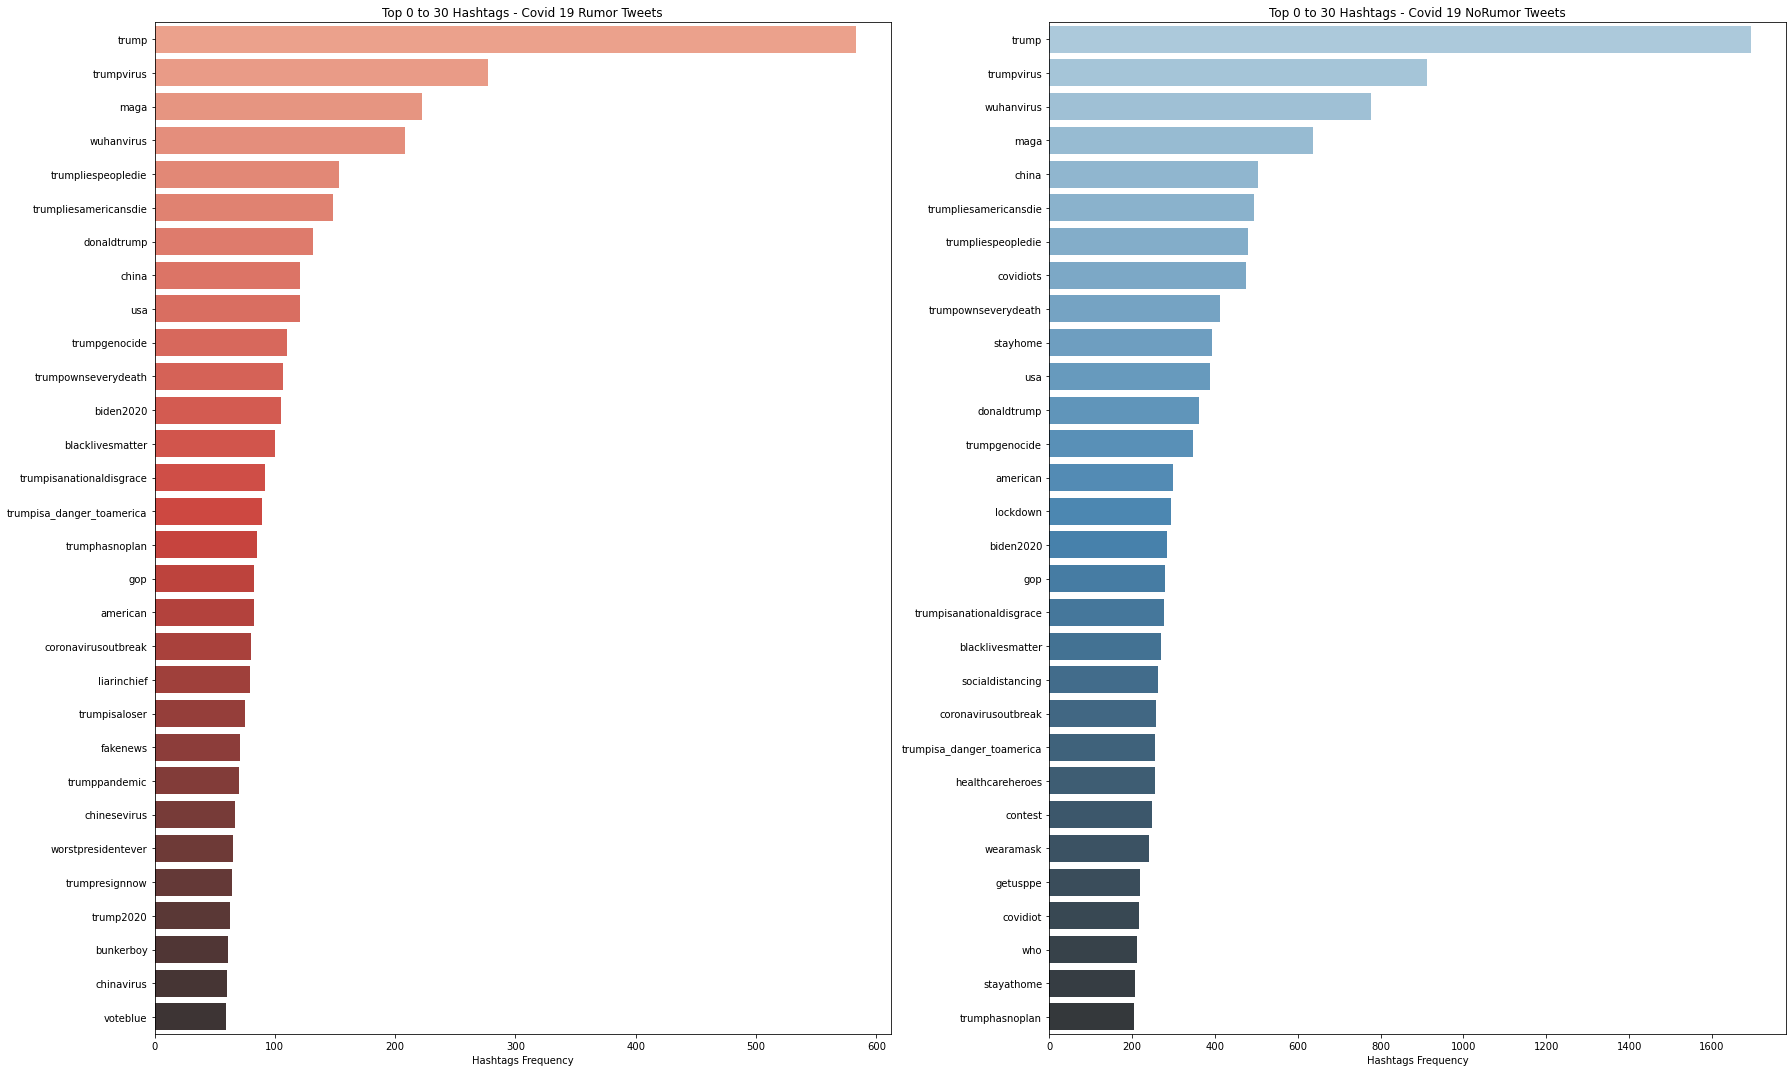

In [19]:
fig, ax = plt.subplots(1,2, figsize=(25,15))
START_INDEX = 0
END_INDEX = 30

sns.barplot(y=[i[0] for i in rumor_hashtag_sorted][START_INDEX:END_INDEX], 
            x=[i[1] for i in rumor_hashtag_sorted][START_INDEX:END_INDEX], 
            orient='h', ax=ax[0], palette="Reds_d")

sns.barplot(y=[i[0] for i in norumor_hashtag_sorted][START_INDEX:END_INDEX], 
            x=[i[1] for i in norumor_hashtag_sorted][START_INDEX:END_INDEX], 
            orient='h', ax=ax[1], palette="Blues_d")

ax[0].set_title(f"Top {START_INDEX} to {END_INDEX} Hashtags - Covid 19 Rumor Tweets")
ax[0].set_xlabel("Hashtags Frequency")
ax[1].set_title(f"Top {START_INDEX} to {END_INDEX} Hashtags - Covid 19 NoRumor Tweets")
ax[1].set_xlabel("Hashtags Frequency")
plt.tight_layout()
plt.show()

## Proportion

判断标准是自己定义的，所以没有统计学依据，可以忽略这种方法，直接用3.3的卡方检验

In [20]:
FREQ_THRESHOLD=200
def pop_less(dict1, threhold=FREQ_THRESHOLD):
    tdict = deepcopy(dict1)
    for k,v in dict1.items():
        if v < threhold:
            tdict.pop(k)
    return tdict

def get_proprotion_dict(dict1):
    allnum = sum(dict1.values())
    tdict = defaultdict(float)
    for k, v in dict1.items():
        tdict[k]=v/allnum
    return tdict

def pop_except_list(dict1, poplist):
    tdict = defaultdict(int)
    for k in poplist:
        if k in dict1:
            tdict[k] = dict1[k]
        else:
            tdict[k] = 0
    return tdict

HASHTAGS_POPLIST = ['covid19', 'coronavirus', 'coronaviruspandemic', 'covid_19', 'covid', 
                   'pandemic', 'corona', 'covid19pandemic', 'covidー19']

def pop_hashtag(dict1, poplist=HASHTAGS_POPLIST):
    tdict = deepcopy(dict1)
    for k in dict1.keys():
        if k in HASHTAGS_POPLIST:
            tdict.pop(k)
    return tdict

In [21]:
hashtag_proportion = get_proprotion_dict(pop_less(hashtag_dict))
rumor_hashtag_proportion = get_proprotion_dict(pop_except_list(rumor_hashtag_dict, list(hashtag_proportion.keys())))
norumor_hashtag_proportion = get_proprotion_dict(pop_except_list(norumor_hashtag_dict, list(hashtag_proportion.keys())))

assert len(list(rumor_hashtag_proportion.keys())) == len(list(hashtag_proportion.keys()))
assert len(list(norumor_hashtag_proportion.keys())) == len(list(hashtag_proportion.keys()))

In [43]:
DIFF_THRESHOLD = 0.1
def proportion_diff(dict1, dict2, alldict, 
                    dict3=rumor_hashtag_dict, dict4=norumor_hashtag_dict, 
                    dict5=hashtag_dict,
                    threshold=DIFF_THRESHOLD):
    rdict = defaultdict(float)
    for k in dict1.keys():
        diff = (dict1[k]-dict2[k])/alldict[k]
#         diff = (dict1[k]-alldict[k])**2/alldict[k] + (dict2[k]-alldict[k])**2/alldict[k]
        if diff>threshold:
            rdict[k] = dict1[k]/alldict[k]-1
        elif -diff>threshold:
            rdict[k] = -dict2[k]/alldict[k]+1
    return rdict

In [44]:
pdiff = proportion_diff(rumor_hashtag_proportion, norumor_hashtag_proportion, hashtag_proportion)
pdiff_sorted = [[item[0], item[1]] for item in sorted(pdiff.items(), key=lambda item: item[1], reverse=True)] 

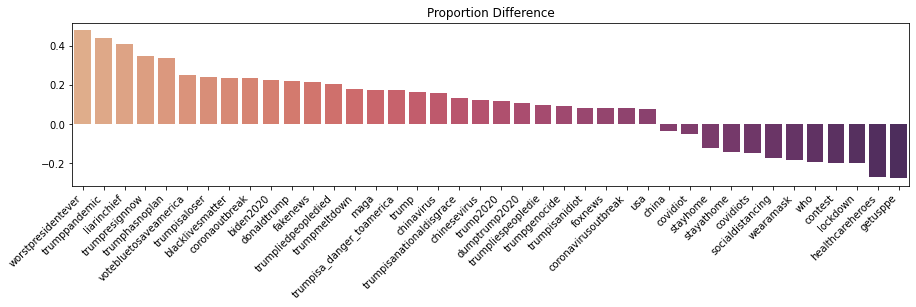

In [76]:
START_INDEX = 0
END_INDEX = 30
fig, ax = plt.subplots(figsize=(15, 3))

sns.barplot(x=[i[0] for i in pdiff_sorted], 
            y=[i[1] for i in pdiff_sorted], 
            orient='v', palette="flare", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Proportion Difference")
plt.show()


## Chi Test

In [46]:
hashtag_popless = pop_less(hashtag_dict)
rumor_hashtag_popless = pop_except_list(rumor_hashtag_dict, list(hashtag_proportion.keys()))
norumor_hashtag_popless = pop_except_list(norumor_hashtag_dict, list(hashtag_proportion.keys()))

assert len(list(rumor_hashtag_popless.keys())) == len(list(hashtag_popless.keys()))
assert len(list(norumor_hashtag_popless.keys())) == len(list(hashtag_popless.keys()))

In [64]:
CHI_THRESHOLD = 3.84
def freq_diff(dict1, dict2, alldict, threshold=CHI_THRESHOLD):
    rmdict_chi = defaultdict(float)
    nrdict_chi = defaultdict(float)
    
    rm_hashtag_sum = sum(list(dict1.values()))
    nr_hashtag_sum = sum(list(dict2.values()))
    hashtag_sum = sum(list(alldict.values()))
    assert rm_hashtag_sum+nr_hashtag_sum==hashtag_sum
    rm_e, nr_e = rm_hashtag_sum/hashtag_sum, nr_hashtag_sum/hashtag_sum
    for k in dict1.keys():
        diff = ((dict1[k]-rm_e*alldict[k])**2)/(rm_e*alldict[k]) + ((dict2[k]-nr_e*alldict[k])**2)/(nr_e*alldict[k])
        if diff>threshold:
            if dict1[k] > rm_e*alldict[k]:
                rmdict_chi[k]=diff
            else:
                nrdict_chi[k]=diff
    return rmdict_chi, nrdict_chi

In [69]:
rmdict_chi, nrdict_chi = freq_diff(rumor_hashtag_popless, norumor_hashtag_popless, hashtag_popless)
rmchi_sorted = [[item[0], item[1]] for item in sorted(rmdict_chi.items(), key=lambda item: item[1], reverse=True)] 
nrchi_sorted = [[item[0], item[1]] for item in sorted(nrdict_chi.items(), key=lambda item: item[1], reverse=True)] 

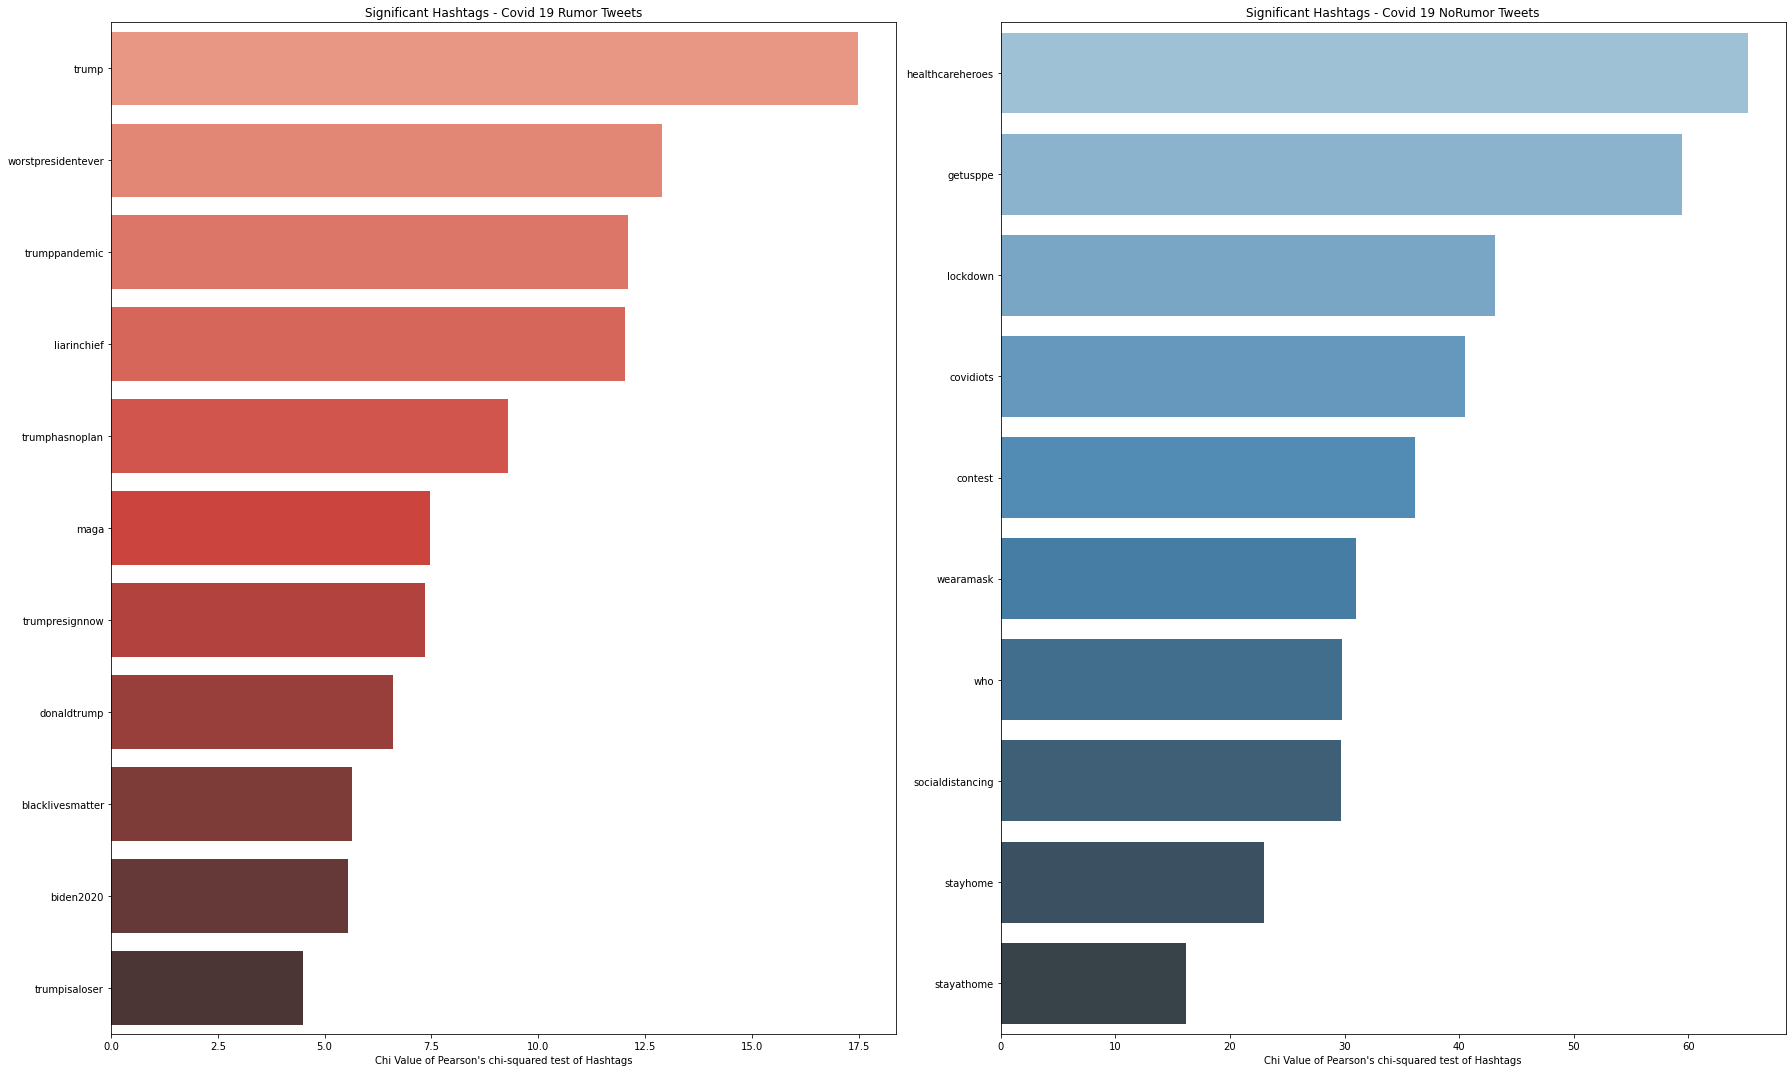

In [73]:
fig, ax = plt.subplots(1,2, figsize=(25,15))

sns.barplot(y=[i[0] for i in rmchi_sorted], x=[i[1] for i in rmchi_sorted], 
            orient='h', ax=ax[0], palette="Reds_d")

sns.barplot(y=[i[0] for i in nrchi_sorted], x=[i[1] for i in nrchi_sorted], 
            orient='h', ax=ax[1], palette="Blues_d")

ax[0].set_title(f"Significant Hashtags - Covid 19 Rumor Tweets")
ax[0].set_xlabel("Chi Value of Pearson's chi-squared test of Hashtags")
ax[1].set_title(f"Significant Hashtags - Covid 19 NoRumor Tweets")
ax[1].set_xlabel("Chi Value of Pearson's chi-squared test of Hashtags")
plt.tight_layout()
plt.show()

# Topic

In [79]:
print(f'English rumor number: {len(covid_rm)}, English no rumor number: {len(covid_nr)}')

English rumor number: 35895, English no rumor number: 165595


In [112]:
from emoji import demojize
import string
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

In [166]:
tokenizer = TweetTokenizer(preserve_case=False,
                           strip_handles=True,
                           reduce_len=True)

nltk.download('stopwords')
english_stopwords = stopwords.words("english")

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return ""
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return ""
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token
        
def remove_stopword(tokens):
#     english_stopwords.extend(['n\'t', 'covid', 'covid19'])
    return [word for word in tokens if (word not in english_stopwords and word not in string.punctuation)]

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )
    normTweet = (
        normTweet.replace("...", "")
        .replace("'s", "")
        .replace("n't", "")
#         .replace(" a . m ", " a.m ")
    )
    
    return remove_stopword(normTweet.split())
#     return ' '.join(normTweet.split())

def join_tokens(tokens):
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weixianf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [167]:
normalizeTweet('According to the New York Times @Tim www.baidu.com')

['according', 'new', 'york', 'times']

In [168]:
covid_en_df['normalized_tokens'] = covid_en_df['text'].apply(normalizeTweet)
covid_en_df['normalized_text'] = covid_en_df['normalized_tokens'].apply(join_tokens)

covid_rm = covid_en_df[covid_en_df.label=='1']
covid_nr = covid_en_df[covid_en_df.label=='0']

C:\Users\weixianf\AppData\Local\Temp\ipykernel_15080\626141093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_en_df['normalized_tokens'] = covid_en_df['text'].apply(normalizeTweet)
C:\Users\weixianf\AppData\Local\Temp\ipykernel_15080\626141093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_en_df['normalized_text'] = covid_en_df['normalized_tokens'].apply(join_tokens)


## Visualization of all the words using word cloud

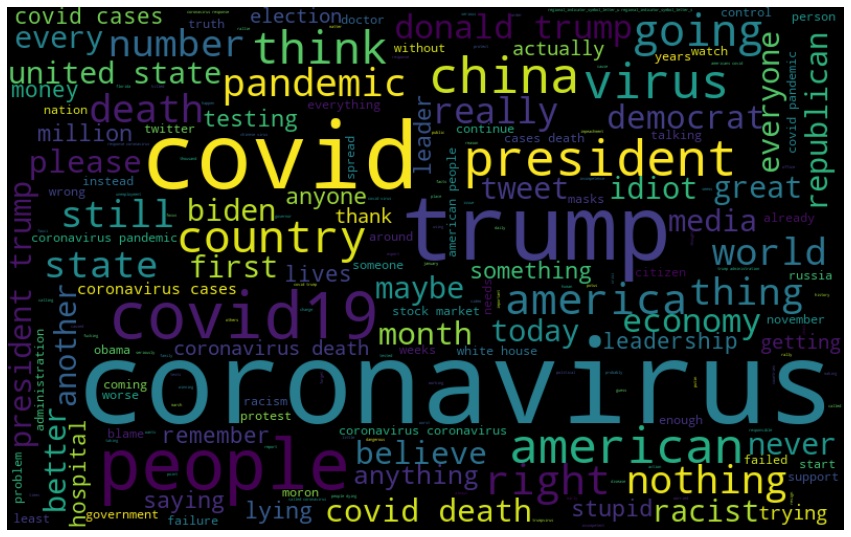

In [169]:
rumor_all_word = ' '.join([text for text in covid_rm['normalized_text']])
rm_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=200, min_word_length=5).generate(rumor_all_word) 
plt.figure(figsize=(15, 12)) 
plt.imshow(rm_wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

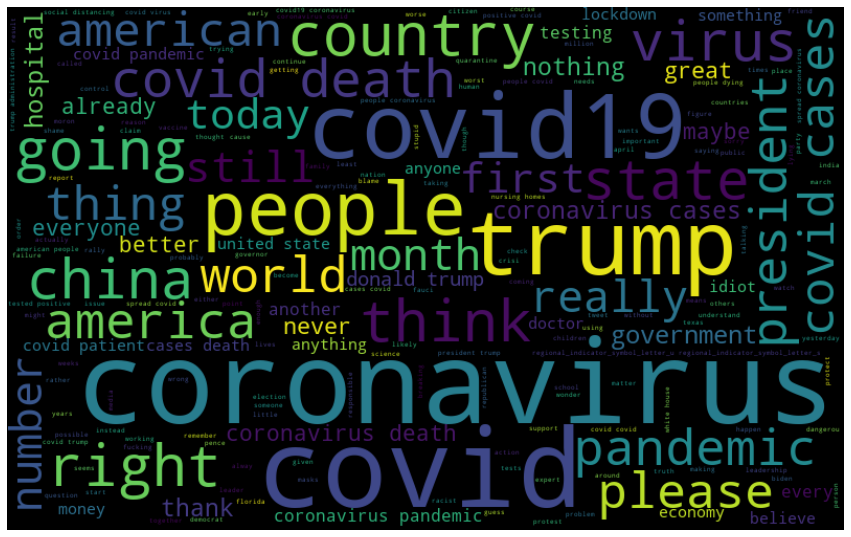

In [170]:
norumor_all_word = ' '.join([text for text in covid_nr['normalized_text']])
nr_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=200, min_word_length=5).generate(norumor_all_word) 
plt.figure(figsize=(15, 12)) 
plt.imshow(nr_wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

## Topic analysis

### Lemmatizer

In [171]:
from nltk.stem import WordNetLemmatizer

In [152]:
lemmatizer = WordNetLemmatizer()

def lemma_tokenlist(tokens):
    tl = []
    for token in tokens:
        tl.append(lemmatizer.lemmatize(token))
    return tl

In [186]:
covid_en_df['lemma_tokens'] = covid_en_df['normalized_tokens'].apply(lemma_tokenlist)
covid_en_df['lemmas_back_to_text'] = covid_en_df['lemma_tokens'].apply(join_tokens)

C:\Users\weixianf\AppData\Local\Temp\ipykernel_15080\3465809905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_en_df['lemma_tokens'] = covid_en_df['normalized_tokens'].apply(lemma_tokenlist)
C:\Users\weixianf\AppData\Local\Temp\ipykernel_15080\3465809905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_en_df['lemmas_back_to_text'] = covid_en_df['lemma_tokens'].apply(join_tokens)


### Topic Base Model

In [183]:
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import GridSearchCV
import pyLDAvis.gensim_models

In [187]:
# Create a id2word dictionary
covid_rm = covid_en_df[covid_en_df.label=='1']
covid_nr = covid_en_df[covid_en_df.label=='0']

id2word = Dictionary(covid_rm['lemma_tokens'])
print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

31988
15104


In [174]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in covid_rm['lemma_tokens']]

In [175]:
# Timing Start
base_model_program_start_time = time.time()

# Instantiating a LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Timing End
base_model_program_end_time = time.time()

#Printing First Model Time
base_model_runtime = round(base_model_program_end_time - base_model_program_start_time, 2)
print(base_model_runtime)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

41.0


In [176]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
covid 19 ” “ people coronavirus american virus 's #covid19

------ Topic 1 ------
's trump covid coronavirus 19 death #covid19 #coronavirus american n't

------ Topic 2 ------
coronavirus covid 19 n't trump ... 's people u american

------ Topic 3 ------
19 covid coronavirus trump u death case 's ... n't

------ Topic 4 ------
coronavirus trump 's people n't 19 president covid one american



In [177]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=covid_rm['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)



Perplexity:  -7.727195424507515

Coherence Score:  0.2888228026679486


In [184]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

C:\ProgramData\Anaconda3\envs\ailab\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008862  0.010100       1        1  25.013097
4      0.023876  0.058294       2        1  22.145886
1     -0.000540  0.007576       3        1  20.758227
3      0.058915 -0.051953       4        1  16.559201
0     -0.073389 -0.024017       5        1  15.523589, topic_info=             Term          Freq         Total Category  logprob  loglift
18          covid  11486.000000  11486.000000  Default  30.0000  30.0000
13             19  11442.000000  11442.000000  Default  29.0000  29.0000
39    coronavirus  15098.000000  15098.000000  Default  28.0000  28.0000
12             's   8903.000000   8903.000000  Default  27.0000  27.0000
248             ”   2036.000000   2036.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
55   #coronavirus    378.601500   2786.571841   Topic5  -5.4300  -0.1333
245          like    332.363993   2475.138457   Topic5  -5.5602  -0.1450
302         death    331.182863   3723.764134   Topic5  -5.5638  -0.5570
243         going    261.158268   1400.724762   Topic5  -5.8013   0.1832
418       country    262.014266   1884.358080   Topic5  -5.7981  -0.1101

[468 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
14635      2  0.894414  #2stupid2quarantine
8859       1  0.105239              #70days
8859       3  0.841912              #70days
8859       5  0.052620              #70days
14829      1  0.152711           #boycotthp
...      ...       ...                  ...
4279       3  0.027322                  🤦‍♀
4279       5  0.054644                  🤦‍♀
9665       2  0.915458                 🤷🏽‍♂
13952      2  0.084086                    󠁧
13952      4  0.840861                    󠁧

[1197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

### Grid Seach 

In [191]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [192]:
lemmas_df = covid_rm['lemmas_back_to_text']
print(type(lemmas_df[0]))

vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(covid_rm['lemmas_back_to_text'])

<class 'str'>


In [ ]:
gs_start_time = time.time()

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

gs_end_time = time.time()

print(gs_end_time - gs_start_time, "seconds to finish")

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

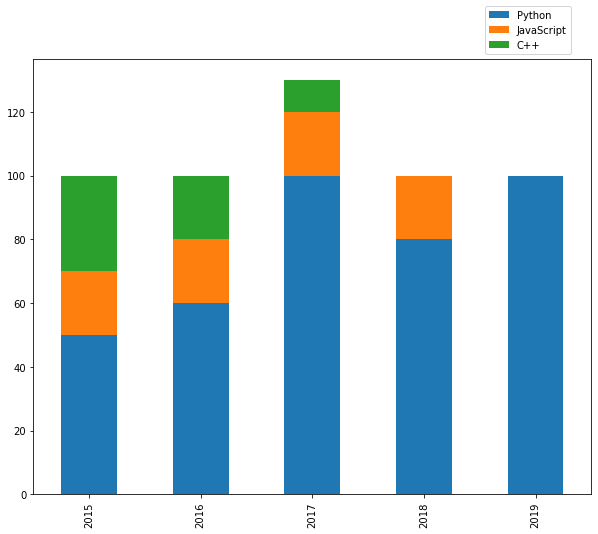

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

years=["2015","2016","2017","2018","2019"]
data={
    "Python":[50,60,100,80,100],
    "JavaScript":[20,20,20,20,0],
    "C++":[30,20,10,0,0],
}

df=pd.DataFrame(data,index=years)

df.plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()